In [90]:
import pandas as pd
import numpy as np
from station import Station
import seaborn as sns
import matplotlib.pyplot as plt
import geopy.distance
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
import mpld3

%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
station_summary = pd.read_csv('data/station_summary.csv')

In [114]:
high_stds = station_summary.sort_values(by='daily_std', ascending=False).iloc[0:10]
# high_stds.set_index('station', inplace=True)

In [93]:
# create geodataframe from stations with highest STDs
def create_geodf(df):
    df.set_index('station', inplace=True)
    geometry = [Point(x,y) for x,y in zip(df['longitude'], df['latitude'])]
    crs = {'init':'epsg:4326'}
    geo_df = gpd.GeoDataFrame(index=df.index, crs=crs, geometry=geometry)
    return geo_df

In [94]:
# check which neighborhood each point belongs in
def assign_neighborhood(geodf, neighdf):
    x=pd.DataFrame()
    assign_dict = {key: geom for key, geom in neighdf['geometry'].items()}
    assign_dict2 = {key: geodf.within(geom) for key, geom in assign_dict.items()}
    x = geodf.assign(**assign_dict2)
    x = x.loc[:, (x != 0).any(axis=0)]
    names=x.columns.tolist()
    names.remove('geometry')
    x['neighborhood'] = x[names].idxmax(axis=1)
    x.drop(columns=names, inplace=True)
    return x

In [95]:
# get polygons for each relevant neighborhood
def get_selected_neighborhoods(points,neighdf):
    for item in points['neighborhood']:
        inds = points.index[points['neighborhood']==item].tolist()
        points.loc[inds,'polygon'] = neighdf.loc[item, 'geometry']

    neighs_withpoints = points.copy()
    neighs_withpoints.rename(columns={'polygon':'geometry', 
                                      'geometry':'points'}, inplace=True)
    x = neighs_withpoints.representative_point().apply(lambda p: p.x)
    y = neighs_withpoints.representative_point().apply(lambda p: p.y)
    neighs_withpoints['xy']= [(x,y) for x,y in zip(x, y)]
    return neighs_withpoints

In [111]:
def make_map_with_points(neighdf, station_points, neighs_withpoints, 
                         neighs_only, offset_xy, cmap, title, handle, annotate=False):

    fig, ax = plt.subplots(figsize=(10,10))
    neighdf.plot(ax=ax,alpha=.7, color='grey')

    neighs_withpoints.plot(ax=ax, cmap=cmap, column='neighborhood', categorical=True, 
                           legend=True,
                           vmin=-1)
    if annotate:
        for n, xy in zip(neighs_only.index.tolist(), offset_xy):
            ax.annotate(n,  xy=xy, ha='center', va='center',
                        color='k', fontsize=14)
    station_points.plot(ax=ax, color='white', marker='o', alpha=.5, markersize=200)
    ax.set_xlabel('Longitude', fontsize=20)
    ax.set_ylabel('Latitude', fontsize=20)
    ax.set_xticklabels(ax.get_xticklabels(),fontsize=16)
    ax.set_yticklabels(ax.get_yticklabels(),fontsize=16)
    plt.title(title, fontsize=24)
    plt.axis('off')
    plt.savefig('figs/map_'+handle+'.png')

In [109]:
# read df
df = pd.read_csv('data/pie_stations_summary.csv')
df['pctchange_2018_2023'] = ((df['2023_predicted_mean']/df['2018_mean'])-1)*100
df=df.loc[0:2]

# read map
neighdf = gpd.read_file(
    'data/Boundaries - Community Areas/geo_export_c539fca7-2c77-4148-be09-2c656a4bc388.shp')
neighdf.set_index('community', inplace=True)
geodf = create_geodf(df)
station_points = assign_neighborhood(geodf,neighdf)
neighs_withpoints=get_selected_neighborhoods(station_points,neighdf)

# run if some points fall in the same neighborhood 
for neigh in neighs_withpoints['neighborhood']:
    num = len(neighs_withpoints[neighs_withpoints['neighborhood']==neigh])
    locs = neighs_withpoints[neighs_withpoints['neighborhood']==neigh].index
    neighs_withpoints.loc[locs, 'freq']=num
neighs_only = neighs_withpoints.drop_duplicates(subset='neighborhood')

offset_xy=[]
xoffsets = [.065, .09, .075]
yoffsets = [.01, -.005, -.003]
for item, xoffset,yoffset in zip(neighs_only['xy'], xoffsets, yoffsets):
    x = item[0]+xoffset
    y = item[1]+yoffset
    offset_xy.append((x,y))

INFO:fiona.ogrext:Failed to auto identify EPSG: 7


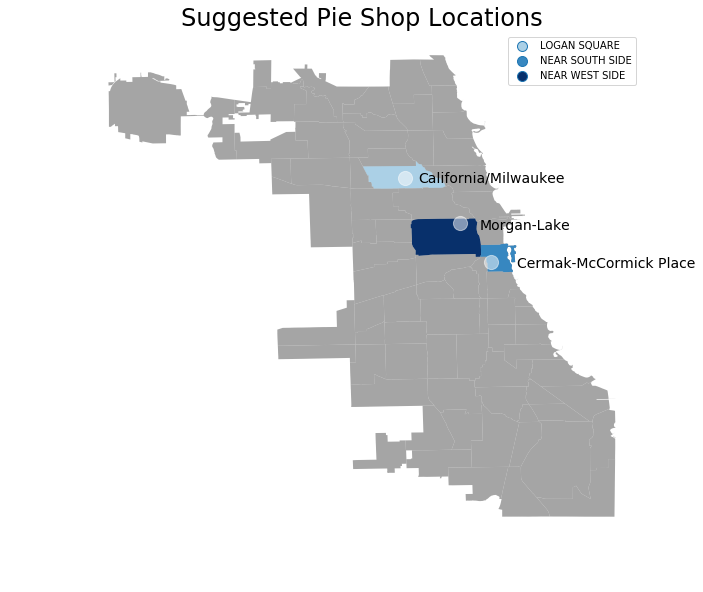

In [112]:
make_map_with_points(neighdf, station_points, neighs_withpoints, 
                         neighs_only, offset_xy, 'Blues',
                     'Suggested Pie Shop Locations', 'pie', annotate=True)

In [115]:
# define df
df = high_stds

# read map
neighdf = gpd.read_file(
    'data/Boundaries - Community Areas/geo_export_c539fca7-2c77-4148-be09-2c656a4bc388.shp')
neighdf.set_index('community', inplace=True)
geodf = create_geodf(df)
station_points = assign_neighborhood(geodf,neighdf)
neighs_withpoints=get_selected_neighborhoods(station_points,neighdf)

# run if some points fall in the same neighborhood 
for neigh in neighs_withpoints['neighborhood']:
    num = len(neighs_withpoints[neighs_withpoints['neighborhood']==neigh])
    locs = neighs_withpoints[neighs_withpoints['neighborhood']==neigh].index
    neighs_withpoints.loc[locs, 'freq']=num
neighs_only = neighs_withpoints.drop_duplicates(subset='neighborhood')

offset_xy=[]
xoffsets = [.065, .09, .075]
yoffsets = [.01, -.005, -.003]
for item, xoffset,yoffset in zip(neighs_only['xy'], xoffsets, yoffsets):
    x = item[0]+xoffset
    y = item[1]+yoffset
    offset_xy.append((x,y))

INFO:fiona.ogrext:Failed to auto identify EPSG: 7


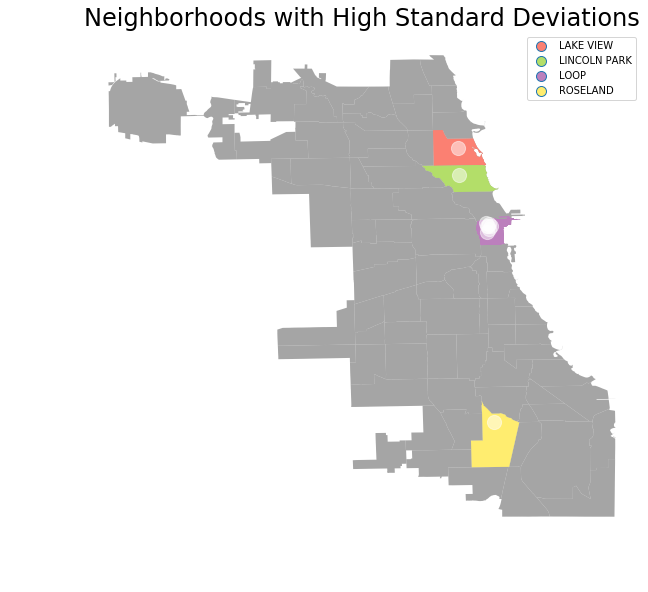

In [124]:
make_map_with_points(neighdf, station_points, neighs_withpoints, 
                         neighs_only, offset_xy, 'Set3',
                     'Neighborhoods with High Standard Deviations', 'high_stds')